In [ ]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [ ]:
# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
import config_util
import grammar
reload(grammar)
reload(config_util)
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

<module 'data_util' from '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [ ]:
from copy import deepcopy
import torch
import numpy as np
import sympy as sp
from parsing import prods_to_prefix, logits_to_prefix, logits_to_prods, eval_from_logits
from config_util import dict_to_config, load_config
from data_util import load_dataset, calc_priors_and_means, create_dataloader, load_wandb_model, create_dataloader_from_wandb, data_from_loader, plot_onehot
from matplotlib import pyplot as plt
torch.manual_seed(41)
torch.set_grad_enabled(False)

# faithful-resonance-144: 24ryl3yz (0.7M params, 0.4M data)
# neat-leaf-286: zrfkvnvd (0.7M params, 1.2M data)
# decent-violet-288: gxdcuae8 (2.5M params, 1.2M data)


# Load model and dataset
model, cfg_dict, cfg = load_wandb_model(run='gxdcuae8', name='last.ckpt')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg_dict, cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Using fallback value for model.value_decoder.size_lin1: 64
{'size_lin1': 64, 'conv_size': 'large'}
Unexpected key in ValueDecoderConfig: size_lin1
Imported model from run "gxdcuae8".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 150 K  | eval
1 | decoder       | Decoder      | 166 K  | eval
2 | value_decoder | ValueDecoder | 2.1 M  | eval
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.817     Total estimated model params size (MB)
0         Modules in train mode
22        Modules in eval mode
DataLoader Summary
--------------------------------------------------
  | Train        | Size: 922398  | Batch: 256   | Batches: 3604 
  | valid        | Size: 102488  | Batch: 256   | Batches: 401  
--------------------------------------------------


## KL regularization term

In [ ]:
x = data_from_loader(train_loader, 'x', idx=range(2))
mean, ln_var = model.encoder(x)
z = model.sample(mean, ln_var)
logits = model.decoder(z, max_length=15)
logits_onehot = logits[:, :, :-1]

y_rule_idx = data_from_loader(train_loader, 'syntax', idx=range(2))

In [ ]:
y_rule_idx = data_from_loader(train_loader, 'syntax', idx=range(2))

cross_entropy = torch.nn.CrossEntropyLoss(reduction='none')
loss = cross_entropy(logits_onehot.reshape(-1, logits_onehot.size(-1)), y_rule_idx.reshape(-1))

In [ ]:
def kl(mean, ln_var):
    """KL divergence between two normal distributions"""
    return -0.5 * torch.mean(torch.sum(1 + ln_var - mean.pow(2) - ln_var.exp(), 1))

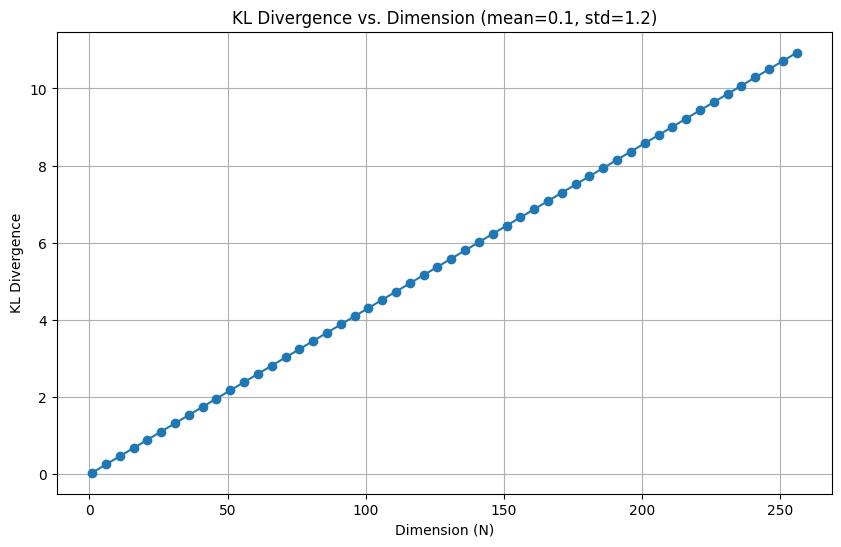

KL divergence at N=1: 0.0427
KL divergence at N=256: 10.9257
Ratio of KL(N=256) to KL(N=1): 256.0000


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define a range of dimensions to test
N_range = np.arange(1, 257, 5)

# Define mean and std values
mean_value = 0.1
std_value = 1.2

kl_values = []

for N in N_range:
    mean = torch.ones(1, N) * mean_value
    std = torch.ones(1, N) * std_value
    ln_var = torch.log(std**2)
    kl = model.kl(mean, ln_var)
    kl_values.append(kl.item())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(N_range, kl_values, '-o')
plt.xlabel('Dimension (N)')
plt.ylabel('KL Divergence')
plt.title(f'KL Divergence vs. Dimension (mean={mean_value}, std={std_value})')
plt.grid(True)
plt.show()

# Print some statistics
print(f"KL divergence at N=1: {kl_values[0]:.4f}")
print(f"KL divergence at N=256: {kl_values[-1]:.4f}")
print(f"Ratio of KL(N=256) to KL(N=1): {kl_values[-1]/kl_values[0]:.4f}")


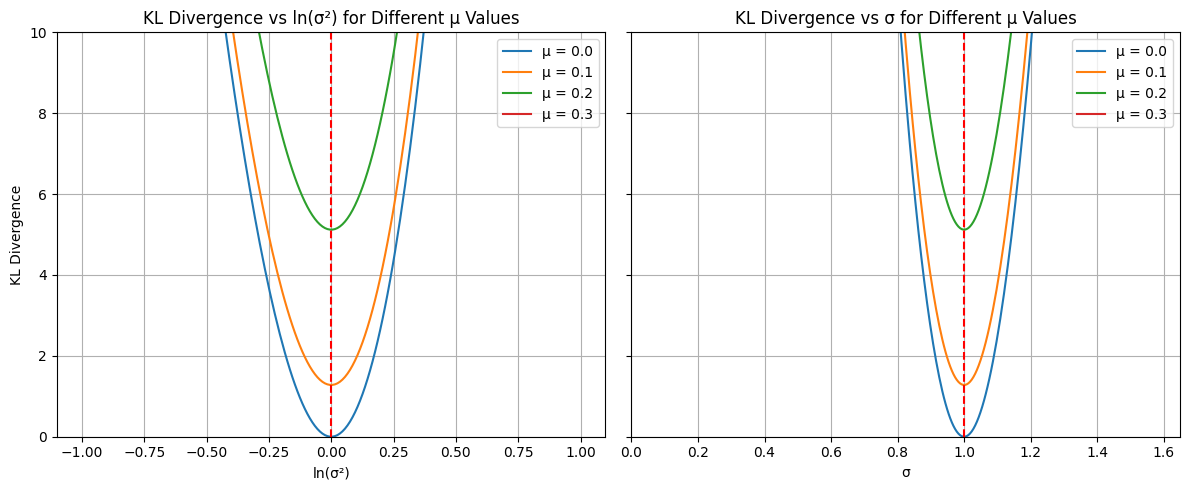

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set up parameters
N = 256  # Number of dimensions
mu_values = [0.0, 0.1, 0.2, 0.3]  # Different mu values to plot
ln_var_range = np.linspace(-1, 1, 200)  # Extended range of ln_var values
std_range = np.exp(ln_var_range / 2)  # Corresponding std values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for mu in mu_values:
    kl_values = []
    for ln_var in ln_var_range:
        mean = torch.ones(1, N) * mu
        ln_var_tensor = torch.ones(1, N) * ln_var
        kl = model.kl(mean, ln_var_tensor)
        kl_values.append(kl.item())
    
    ax1.plot(ln_var_range, kl_values, label=f'μ = {mu}')
    ax2.plot(std_range, kl_values, label=f'μ = {mu}')

ax1.set_xlabel('ln(σ²)')
ax1.set_ylabel('KL Divergence')
ax1.set_title('KL Divergence vs ln(σ²) for Different μ Values')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('σ')
ax2.set_title('KL Divergence vs σ for Different μ Values')
ax2.legend()
ax2.grid(True)

# Set more appropriate limits for better visibility
ax1.set_ylim(0, 10)  # Adjust as needed based on your actual KL divergence values
ax2.set_ylim(0, 10)  # Adjust as needed based on your actual KL divergence values
ax2.set_xlim(0, np.max(std_range))

# Add vertical lines at ln(σ²) = 0 (σ = 1) and σ = 1
ax1.axvline(x=0, color='r', linestyle='--', label='σ = 1')
ax2.axvline(x=1, color='r', linestyle='--', label='σ = 1')

plt.tight_layout()
plt.show()


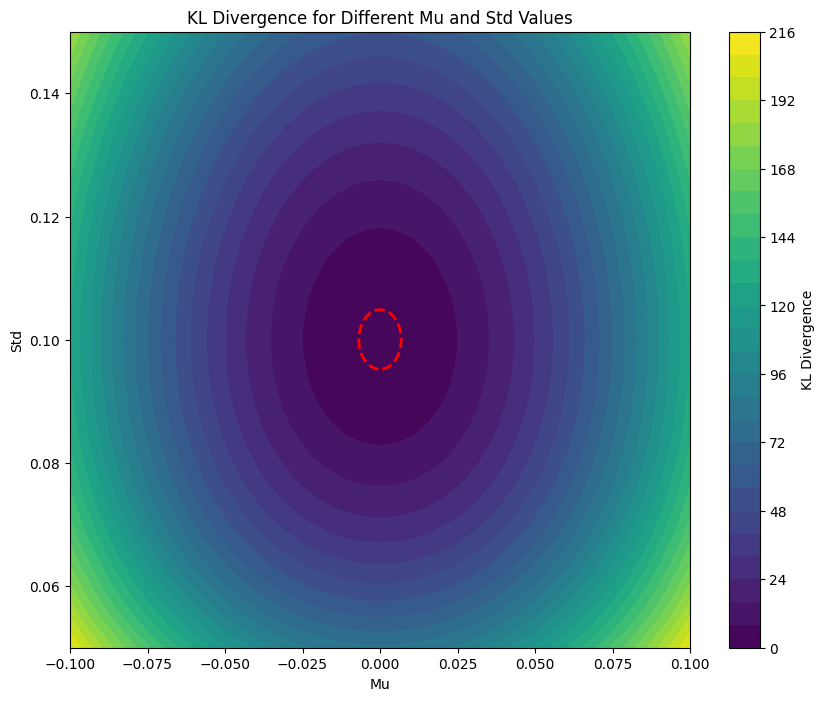

Maximum KL divergence: 209.45 at mu=-0.10, std=0.05


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

N = 256
prior_var = 0.1**2

def calc_kl(prior_var, mean, ln_var):
    """KL divergence between N(mean, exp(ln_var)) and N(0, prior_std^2). Returns a positive definite scalar."""
    kl_per_sample = 0.5 * torch.sum(  # Sum over all dimensions
        -ln_var + math.log(prior_var) -1 + (mean**2 + ln_var.exp())/prior_var,
        dim=1
    )
    return torch.mean(kl_per_sample)  # Average over samples


# Sweep over mu and std values
mean_range = np.linspace(-0.1, 0.1, 200)
std_range = np.linspace(0.05, 0.15, 200)
mean_grid, std_grid = np.meshgrid(mean_range, std_range)

kl_values = np.zeros_like(mean_grid)

for i in range(mean_grid.shape[0]):
    for j in range(mean_grid.shape[1]):
        mean = torch.ones(1, N) * mean_grid[i, j]
        std = torch.ones(1, N) * std_grid[i, j]
        ln_var = torch.log(std**2)
        kl = calc_kl(prior_var, mean, ln_var)
        kl_values[i, j] = kl.item()

# Plot the results
plt.figure(figsize=(10, 8))
contour = plt.contourf(mean_grid, std_grid, kl_values, levels=30, cmap='viridis')
plt.colorbar(contour, label='KL Divergence')
plt.xlabel('Mu')
plt.ylabel('Std')
plt.title('KL Divergence for Different Mu and Std Values')

# Draw a line where the value is exactly 0.02
plt.contour(mean_grid, std_grid, kl_values, levels=[0.6], colors='red', linestyles='dashed', linewidths=2)
plt.show()

# Print the maximum KL divergence value and its corresponding mu and std
max_kl = np.max(kl_values)
max_idx = np.unravel_index(np.argmax(kl_values), kl_values.shape)
max_mu = mean_grid[max_idx]
max_std = std_grid[max_idx]
print(f"Maximum KL divergence: {max_kl:.2f} at mu={max_mu:.2f}, std={max_std:.2f}")